<a href="https://colab.research.google.com/github/Varunsaistark/reinforcment_learning/blob/main/duellingddqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch 
import torch.nn as nn
 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import gym
from collections import namedtuple 
import random

import matplotlib.pyplot as plt


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
num_epochs=4
alpha=1e-4
batch_size=512

In [5]:
Experience = namedtuple('Experience',('state','action','next_state','reward','done'))

In [6]:
 
class replaymemory():
  def __init__(self,capacity):
    self.capacity=capacity
    self.memory=[]
    self.push_count=0
  
  def push(self,experience):
    if(self.push_count>self.capacity):
      self.memory[self.push_count%self.capacity]=experience
    else:
      self.memory.append(experience)
    self.push_count+=1
  
  
  def sample(self,batch_size):
    e=random.sample(self.memory,batch_size)
    #print(type(e1.state))
    states=torch.tensor([e1.state for e1 in e]).to(device)
    actions=torch.tensor([e1.action for e1 in e]).to(device)
    next=torch.tensor([e1.next_state for e1 in e]).to(device)
    rewards = torch.tensor(([e1.reward for e1 in e])).to(device)
    dones = torch.tensor([e1.done for e1 in e])
    
    #states=states.view(64,1,80,160)
    return states.float(),actions,next,rewards,dones
  
  def can_provide(self,batch_size):
    return len(self.memory)>=batch_size

In [7]:
#from google.colab import drive
 
#drive.mount('/content/drive')

In [8]:
class eps_strat():
  def __init__(self,num_actions,start,decay,end,device):
    self.cur_step=0
    self.num=num_actions
    self.device=device
    self.start=start
    self.decay=decay
    self.end=end
  def get_action(self,policy,state,step):
    self.cur_step=step
    ep=self.end+(self.start-self.end) * np.exp(-1*self.cur_step*self.decay)
    #self.cur_step=self.cur_step+1
    #print(ep,self.cur_step)
    if ep>random.random():
      #print("NO")
      action=random.randrange(self.num)
      return action
    else:
      policy.eval()
      with torch.no_grad():
        #print("yes")
        return torch.argmax(policy(state)).item()
  def get_value(self,step):
    self.cur_step=step
    ep=self.end+(self.start-self.end) * np.exp(-1*self.cur_step*self.decay)
    return ep


In [9]:
class duelling(nn.Module):
  def __init__(self,num_actions):
    super(duelling,self).__init__()
    self.a = num_actions
    self.fc1_value = nn.Linear(4,512)
    self.fc2_value = nn.Linear(512,64)
    self.fc3_value = nn.Linear(64,1)
    self.fc1_adv = nn.Linear(4,512)
    self.fc2_adv = nn.Linear(512,64)
    self.fc3_adv = nn.Linear(64,self.a)
  def forward(self,x):
    state_value = F.relu(self.fc1_value(x))
    state_value = F.relu(self.fc2_value(state_value))
    state_value = self.fc3_value(state_value)
    advantage = F.relu(self.fc1_adv(x))
    advantage = F.relu(self.fc2_adv(advantage))
    advantage = self.fc3_adv(advantage)

    return state_value+advantage-torch.mean(advantage)



In [10]:
def soft_update(local,target,t):
  for target_param,local_param in zip(target.parameters(),local.parameters()):
    target_param.data.copy_(t*local_param.data+(1-t)*target_param.data)

In [11]:
env = gym.make('CartPole-v0')
a = env.action_space.n

In [12]:
target_net = duelling(a).to(device)
policy=duelling(a).to(device)
soft_update(policy,target_net,1)



#optimizer=torch.optim.SGD(model.parameters(),lr=alpha)

In [13]:
mem=replaymemory(10000)

In [14]:
env = env.unwrapped
ob=env.reset()

done_1=False
print(ob.shape)

gamma=torch.tensor(0.99)

start=1
end=0.00001
decay=0.01


#tau for soft update
 
tau=0.89

t_decay=eps_strat(2,0.9,0.01,0.001,device)
print(tau)
print(env.action_space.n)

(4,)
0.89
2


0 26.0


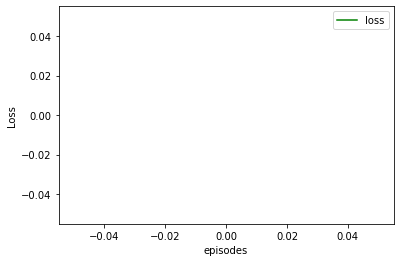

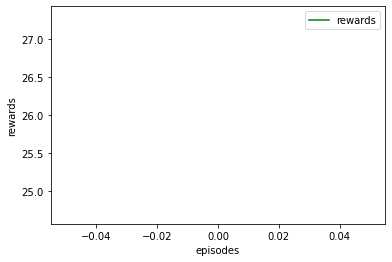

1 17.0
2 18.0
3 11.0
4 12.0
5 13.0
6 11.0
7 12.0
8 12.0
9 10.0
10 12.0
11 10.0
12 13.0
13 9.0
14 13.0
15 13.0
16 17.0
17 19.0
18 19.0
19 36.0
20 17.0
21 11.0
22 17.0
23 19.0
24 47.0
25 11.0
26 79.0
27 16.0
28 27.0
29 9.0
30 9.0
31 37.0
32 10.0
33 63.0
34 8.0
35 49.0
36 103.0
37 91.0
38 48.0
39 39.0
40 38.0
41 78.0
42 10.0
43 65.0
44 67.0
45 49.0
46 45.0
47 58.0
48 60.0
49 41.0
50 54.0
51 61.0
52 30.0
53 9.0
54 9.0
55 9.0
56 57.0
57 82.0
58 9.0


KeyboardInterrupt: ignored

In [15]:
FILE='/content/drive/MyDrive/target_duellingcartpole.pth'
File='/content/drive/MyDrive/model_duellingcartpole.pth'
#torch.save(policy.state_dict(),File)
step=0
step_1=0
eps=0
lo=[]
re=[]
num_episodes=10000
for eps in range(num_episodes):
  
  reward_sum=0
  state=env.reset()
  
  done_1=False
  
  while not done_1:
    step=step+1
    ep=eps_strat(2,start,decay,end,device)
    st = torch.tensor(state)
    action= ep.get_action(policy,st.float().to(device),step)
    #print(action)
    
    next_state,reward,done_1,info=env.step(action)

 

    
 
    e1=Experience(state,action,next_state,reward,done_1)

    mem.push(e1)
    reward_sum+=reward
    
    state=next_state
    #print(reward)
  
  re.append(reward_sum)
  #if reward_sum>280:
  print(eps,reward_sum)
  
  if mem.can_provide(64):
    epochs=5
    for i in range(epochs):
      states_1,actions,next_states,rewards,done=mem.sample(64)
      ex = policy.forward(next_states.float()).detach().cpu().numpy().tolist()
     
      target_q=target_net.forward(next_states.float()).detach().cpu().numpy()
      #print(target_q)
      j=[t.index(max(t)) for t in ex]
     
      target_q=torch.tensor([target_q[i][j[i]] for i in range(len(j))]).to(device).detach()
      #cv2_imshow(states_1[0][0].cpu(that loss becoming 0 is still persisi).numpy())
      done=done.int().to(device)
  
      q=(rewards+gamma*(target_q*(1-done))).detach()
      q=q.unsqueeze(1)
    #print(gamma*(target_q*(1-done)))
      l=torch.tensor([actions[i] for i in range(64)]).to(device)
      l=l.unsqueeze(1)
      exp_q=policy.forward(states_1.float()).gather(-1,l)
    
      loss=nn.MSELoss()
      tr=loss(exp_q,q)
      #print(tr)
    #print("loss is {}".format(tr))
      lo.append(tr)
    #print(tr)
      optimizer= torch.optim.Adam(policy.parameters(),lr=alpha)
      optimizer.zero_grad()
      tr.backward()
    # optimizer
    
      optimizer.step()
    
   
  if eps%100 ==0:
    #step_1=step_1+1
    #tau=t_decay.get_value(step_1)
    soft_update(policy,target_net,0.78) 
    episodes=range(len(lo))
    epi=range(len(re))
    plt.plot(episodes,lo,'g',label='loss')
    plt.xlabel('episodes')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 
    plt.plot(epi,re,'g',label='rewards')
    plt.xlabel('episodes')
    plt.ylabel('rewards')
    plt.legend()
    plt.show() 
  #if eps%50==0:
   # torch.save(target_net.state_dict(),FILE)
   # torch.save(policy.state_dict(),File)
   # print("Weights saved")